# Machine learning assignment 4: k-means Cluster Analysis

## Loading data

In [211]:
%matplotlib inline
import numpy
import pandas
from pandas import Series, DataFrame
from sklearn import preprocessing
from sklearn.cluster import KMeans

data = pandas.read_csv('hour.csv', low_memory=False)
print("Number of observations: ", len(data))
data.head()

Number of observations:  17379


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [212]:
seasmap = {1: '1. Winter', 2:'2. Spring', 3:'3. Summer', 4:'4. Fall'}
data['season'] = data['season'].map(seasmap)
selected_vars = ['temp','hum','windspeed']
cluster = data[selected_vars].copy()
for i in selected_vars:
    cluster[i] = preprocessing.scale(cluster[i].astype('float64'))

In [213]:
from sklearn.cross_validation import train_test_split
clus_train, clus_test = train_test_split(cluster, test_size=.3, random_state=123)

In [214]:
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(numpy.mean(numpy.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)))

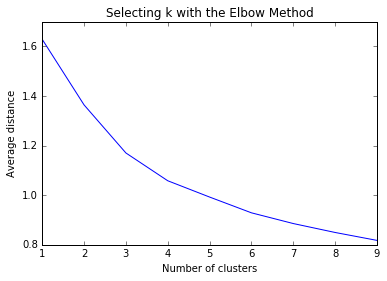

In [215]:
import matplotlib.pylab as plt
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method');

In [216]:
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

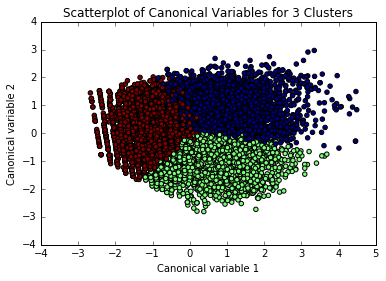

In [217]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

In [218]:
clus_train.reset_index(level=0, inplace=True)

In [219]:
cluslist=list(clus_train['index'])
labels=list(model3.labels_)
newlist=dict(zip(cluslist, labels))
newclus=DataFrame.from_dict(newlist, orient='index')
newclus.columns = ['cluster']
newclus.head()

,cluster
0,2
1,2
2,2
3,2
4,2


In [220]:
newclus.reset_index(level=0, inplace=True)

In [221]:
merged_train=pandas.merge(clus_train, newclus, on='index')
merged_train.head(n=20)

,index,temp,hum,windspeed,cluster
0,1859,-0.815304,1.258375,0.519896,2
1,7302,-0.919172,0.169865,-1.553889,2
2,17094,-0.919172,0.169865,-1.553889,2
3,17009,-0.607566,0.999206,0.031899,2
4,1636,-0.295959,-1.125980,1.374096,0
5,7831,-0.088222,0.480868,0.519896,2
6,11537,0.119516,-0.400306,-0.211691,1
7,12655,0.950466,-1.125980,-0.699689,1
8,2693,0.431122,1.310209,0.764304,2
9,10435,0.119516,0.273533,-0.456099,2


In [222]:
merged_train.cluster.value_counts()

2    5019
1    3692
0    3454
Name: cluster, dtype: int64

In [223]:
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
               index      temp       hum  windspeed
cluster                                            
0        7839.845686 -0.829317 -0.730113   0.737941
1        9192.658722  1.075323 -0.505027   0.069672
2        8881.535764 -0.230853  0.862511  -0.556571


## Validate by weathersituation

In [224]:
ws_data=data[['weathersit','season']]
# split ws data into train and test sets
ws_train, ws_test = train_test_split(ws_data, test_size=.3, random_state=123)
ws_train1=pandas.DataFrame(ws_train)
ws_train1.reset_index(level=0, inplace=True)
merged_train_all=pandas.merge(ws_train1, merged_train, on='index')
sub1 = merged_train_all[['weathersit','season', 'cluster']].dropna()

In [225]:
pandas.crosstab(sub1.weathersit, sub1.cluster)

cluster,0,1,2
weathersit,,,
1,2538,2924,2526
2,762,667,1758
3,154,101,734
4,0,0,1


In [226]:
pandas.crosstab(sub1.season, sub1.cluster)

cluster,0,1,2
season,,,
1. Winter,1840,87,1105
2. Spring,639,1155,1277
3. Summer,34,2099,1012
4. Fall,941,351,1625
